# Enhanced Round Robin with Dynamic Time Quantum Implementation

### Imports and Setup

In [90]:
import matplotlib.pyplot as plt
import math

# This is an abstract representation of a process in a CPU scheduler.
class Process:
    def __init__(self, pid, arrival, burst):
        self.pid = pid
        self.arrival = arrival
        self.burst = burst
        self.remaining = burst
        self.start = None
        self.end = None
        self.done = False
        self.execution_log = []
    
    def __repr__(self):
        # So we can stringify the process
        return f"{self.pid}(AT={self.arrival}, BT={self.burst}, RT={self.remaining})"
    
def compute_metrics(finished_processes):
    total_waiting_time = 0
    total_turnaround_time = 0
    n = len(finished_processes)
    for p in finished_processes:
        turnaround = p.end - p.arrival  # Total time in system.
        waiting = turnaround - p.burst   # Time in RQ.
        total_turnaround_time += turnaround
        total_waiting_time += waiting
    avg_waiting = total_waiting_time / n
    avg_turnaround = total_turnaround_time / n
    return avg_waiting, avg_turnaround

def merge_timeline(timeline):
    if not timeline:
        return []

    merged = []
    curr_label, curr_start, curr_end = timeline[0]

    for label, start, end in timeline[1:]:
        # if same label and directly adjacent, extend the current segment
        if label == curr_label and start == curr_end:
            curr_end = end
        else:
            # otherwise, push the finished segment and start a new one
            merged.append((curr_label, curr_start, curr_end))
            curr_label, curr_start, curr_end = label, start, end

    # don't forget the last segment
    merged.append((curr_label, curr_start, curr_end))
    return merged


def plot_gantt_charts(timeline, title, chunk_size=5):
    timeline = merge_timeline(timeline)

    num_chunks = math.ceil(len(timeline) / chunk_size)
    fig, axes = plt.subplots(
        nrows=num_chunks,
        ncols=1,
        figsize=(15, 2.5 * num_chunks),
    )
    if num_chunks == 1:
        axes = [axes]

    for idx, ax in enumerate(axes):
        chunk = timeline[idx * chunk_size : (idx + 1) * chunk_size]
        # Hide all but bottom spine
        for spine in ("top", "left", "right"):
            ax.spines[spine].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        #Hide the entire x-axis
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Set per‑chunk x‑limits
        x_start = chunk[0][1] if idx > 0 else 0
        x_end = max(end for _, _, end in chunk)
        ax.set_xlim(x_start, x_end)

        # Plot bars and tick labels
        for proc, start, end in chunk:
            ax.barh(
                y=1,
                width=end - start,
                left=start,
                height=0.6,
                facecolor="none",
                edgecolor="black",
                linewidth=1.5,
            )
            mid = (start + end) / 2
            ax.text(mid, 1, proc, ha="center", va="center")
            ax.text(start, 0.6, str(start), ha="center")
            ax.text(end,   0.6, str(end),   ha="center")

        # Hide the x-axis label
        ax.xaxis.label.set_visible(False)

    fig.suptitle(title, y=0.98, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

<div class="alert alert-block alert-info"> <b>NOTE</b> Python 3 uses the "ties to even" rounding rule (<a href="https://en.wikipedia.org/wiki/IEEE_754#Roundings_to_nearest">IEEE 754</a>) so we need a custom round implementation that does in the "ties to away"</div>

In [91]:
import decimal

def round_away(n):
    d = decimal.Decimal(str(n))
    rounded = d.quantize(decimal.Decimal('1'), rounding=decimal.ROUND_HALF_UP)
    return int(rounded)

## Algorithm Implementation

In [92]:
def calculate_quantum(ready_queue):
    if len(ready_queue) == 0:
        return 0
    index = max(round_away(0.8 * len(ready_queue)), 1) - 1 
    return ready_queue[index].remaining

In [93]:
def enhanced_round_robin(processes):
    current_time = 0
    RQ = []            
    finished = []
    timeline = []
    context_switches = 0
    last_pid = None

    pending = sorted(processes, key=lambda p: p.arrival)
    
    running_process = None
    exec_start = None      

    while len(finished) < len(processes):
        while pending and pending[0].arrival <= current_time:
            proc = pending.pop(0)
            RQ.append(proc)
        
        if running_process is None and not RQ:
            current_time = pending[0].arrival
            continue

        if running_process is None:
            # In the paper, when the CPU is free, we compute QT based on the available processes.
            QT = calculate_quantum(RQ)
            # Select the process with minimum remaining burst (SRQ head).
            SRQ = sorted(RQ, key=lambda p: p.remaining)
            p = SRQ[0]
            RQ.remove(p)

            running_process = p
            if p.start is None:
                p.start = current_time

            # Start a context switch
            if last_pid is not None and last_pid != p.pid:
                context_switches += 1
            last_pid = p.pid
            # Record the start time for this execution slice.
            exec_start = current_time

        # In every time unit of execution, recalc QT based on all available processes.
        available_for_quantum = list(RQ)
        if running_process:
            available_for_quantum.append(running_process)
        QT = calculate_quantum(available_for_quantum)

        one_third_QT = QT / 3

        # Before executing the next time unit, check the preemption condition.
        if running_process and RQ:
            fbt = min(RQ, key=lambda p: p.remaining).remaining
            if running_process.remaining > one_third_QT and fbt <= one_third_QT:
                
                # Preempt the running process.
                timeline.append((running_process.pid, exec_start, current_time))
                running_process.execution_log.append((exec_start, current_time))
                
                RQ.append(running_process)
               
                running_process = None
                continue

        # Execute one time unit.
        current_time += 1
        running_process.remaining -= 1

        # Check for new arrivals during execution.
        while pending and pending[0].arrival <= current_time:
            proc = pending.pop(0)
            RQ.append(proc)

        # If the running process has exhausted the current quantum,
        if (current_time - exec_start) >= QT:
            # End of current quantum slice.
            timeline.append((running_process.pid, exec_start, current_time))
            running_process.execution_log.append((exec_start, current_time))

            if running_process.remaining <= 0:
                # Finished.
                running_process.end = current_time
                running_process.done = True
                finished.append(running_process)
            else:
                # Process not finished; place it back in RQ.
                RQ.append(running_process)
               

            running_process = None
            continue

        # If the running process finished before the quantum expires, note it.
        if running_process.remaining <= 0:
            timeline.append((running_process.pid, exec_start, current_time))
            running_process.execution_log.append((exec_start, current_time))

            running_process.end = current_time
            running_process.done = True

            finished.append(running_process)
            running_process = None

    return finished, timeline, context_switches

## Running Algorithm With Sample Process Sets
### Ascending Order

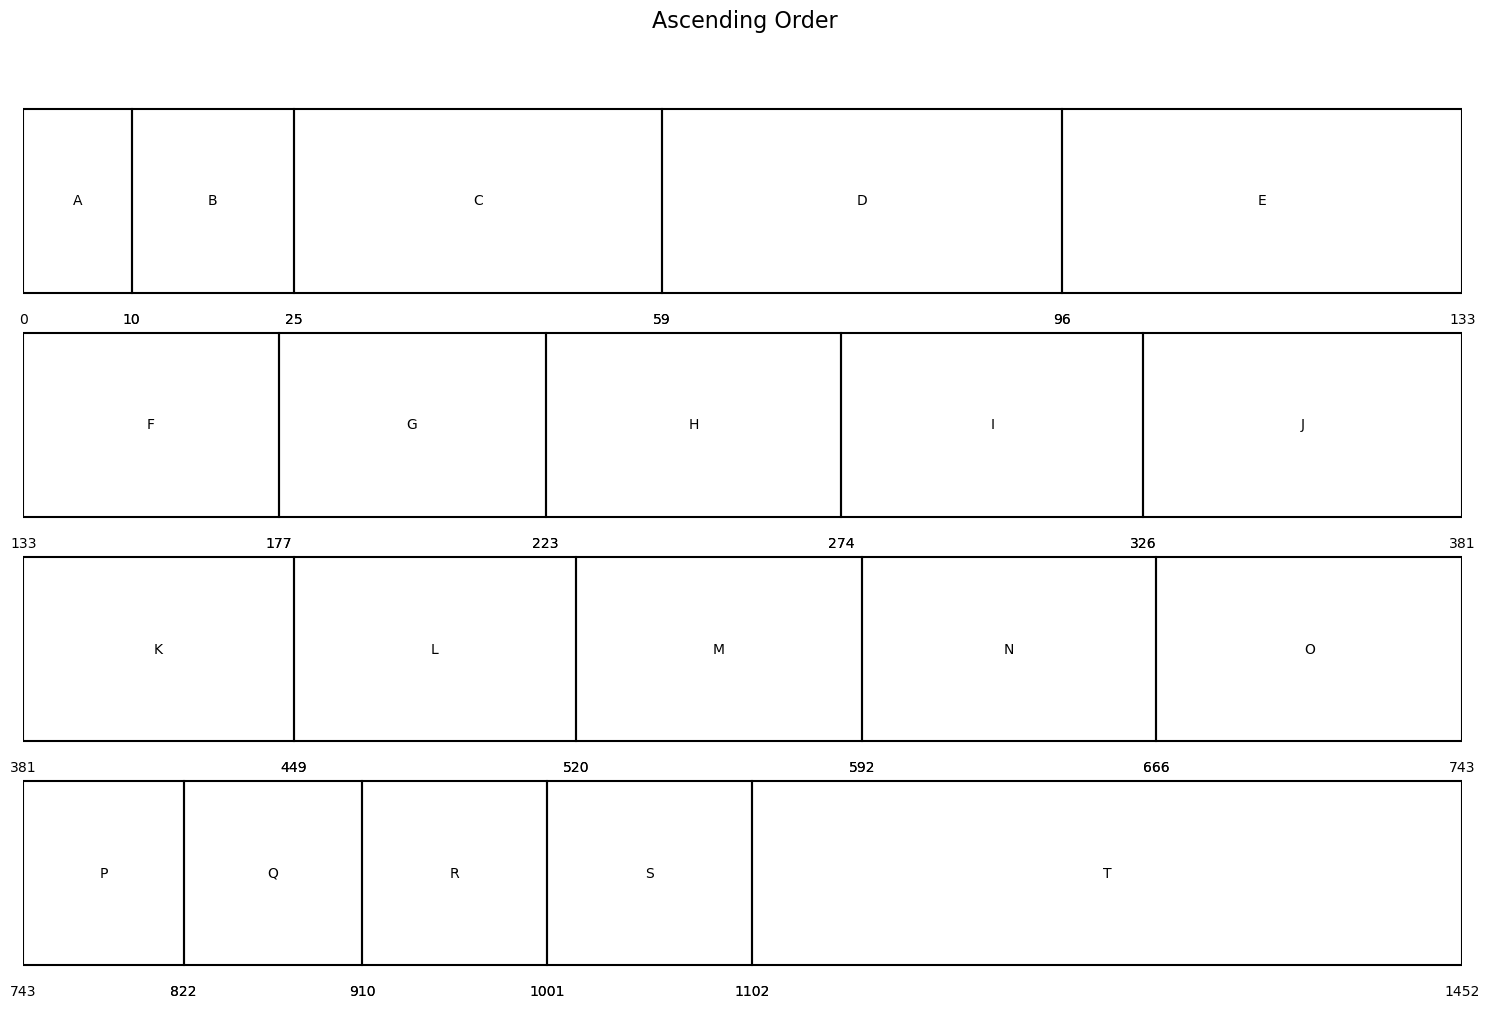

Context Switches: 19
Average Waiting Time: 415.95
Average Turnaround Time: 488.55


In [94]:
processes = [
    Process('A', 0, 10),
    Process('B', 1, 15),
    Process('C', 2, 34),
    Process('D', 3, 37),
    Process('E', 4, 37),
    Process('F', 5, 44),
    Process('G', 6, 46),
    Process('H', 7, 51),
    Process('I', 8, 52),
    Process('J', 9, 55),
    Process('K', 10, 68),
    Process('L', 11, 71),
    Process('M', 12, 72),
    Process('N', 13, 74),
    Process('O', 14, 77),
    Process('P', 15, 79),
    Process('Q', 16, 88),
    Process('R', 17, 91),
    Process('S', 18, 101),
    Process('T', 19, 350),
]

finished, timeline, cs = enhanced_round_robin(processes)
avg_waiting, avg_turnaround = compute_metrics(finished)
plot_gantt_charts(timeline, "Ascending Order")
print("Context Switches:", cs)
print("Average Waiting Time:", avg_waiting)
print("Average Turnaround Time:", avg_turnaround)

### Descending Order

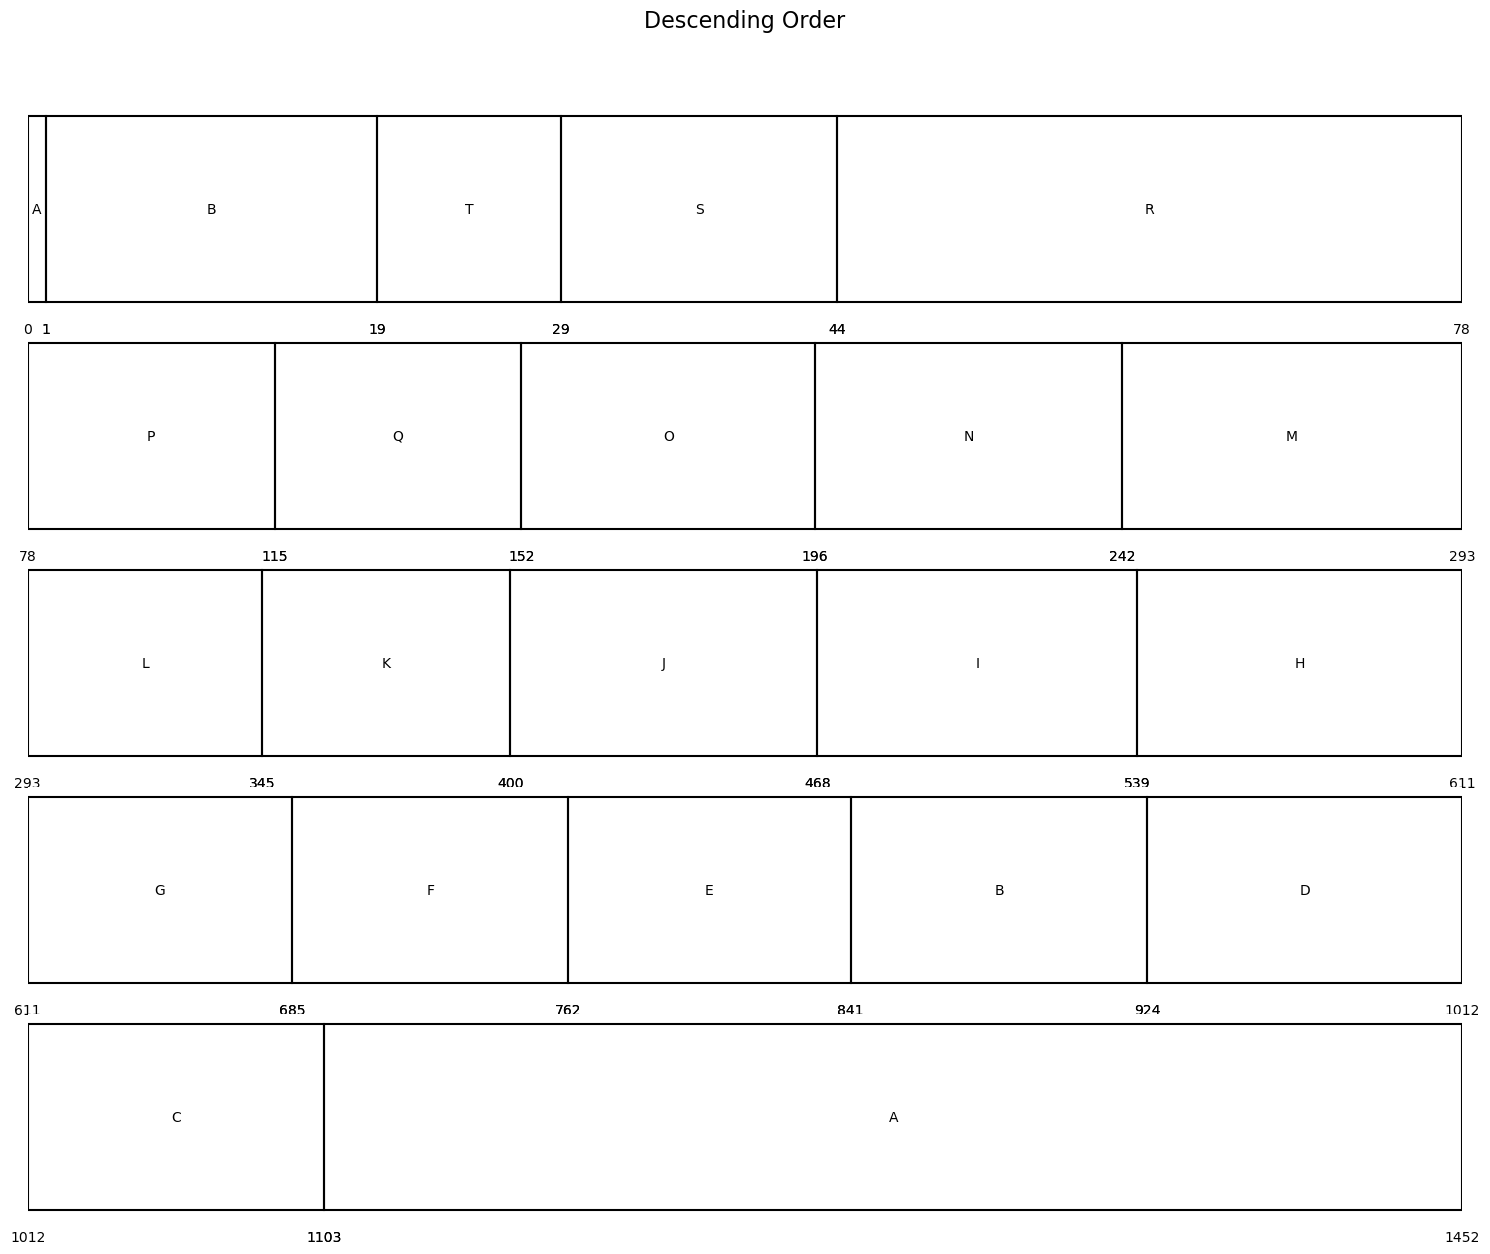

Context Switches: 21
Average Waiting Time: 432.45
Average Turnaround Time: 505.05


In [95]:
processes = [
    Process('A', 0, 350),
    Process('B', 1, 101),
    Process('C', 2, 91),
    Process('D', 3, 88),
    Process('E', 4, 79),
    Process('F', 5, 77),
    Process('G', 6, 74),
    Process('H', 7, 72),
    Process('I', 8, 71),
    Process('J', 9, 68),
    Process('K', 10, 55),
    Process('L', 11, 52),
    Process('M', 12, 51),
    Process('N', 13, 46),
    Process('O', 14, 44),
    Process('P', 15, 37),
    Process('Q', 16, 37),
    Process('R', 17, 34),
    Process('S', 18, 15),
    Process('T', 19, 10),
]

finished, timeline, cs = enhanced_round_robin(processes)
avg_waiting, avg_turnaround = compute_metrics(finished)
plot_gantt_charts(timeline, "Descending Order")
print("Context Switches:", cs)
print("Average Waiting Time:", avg_waiting)
print("Average Turnaround Time:", avg_turnaround)

### Random Order:

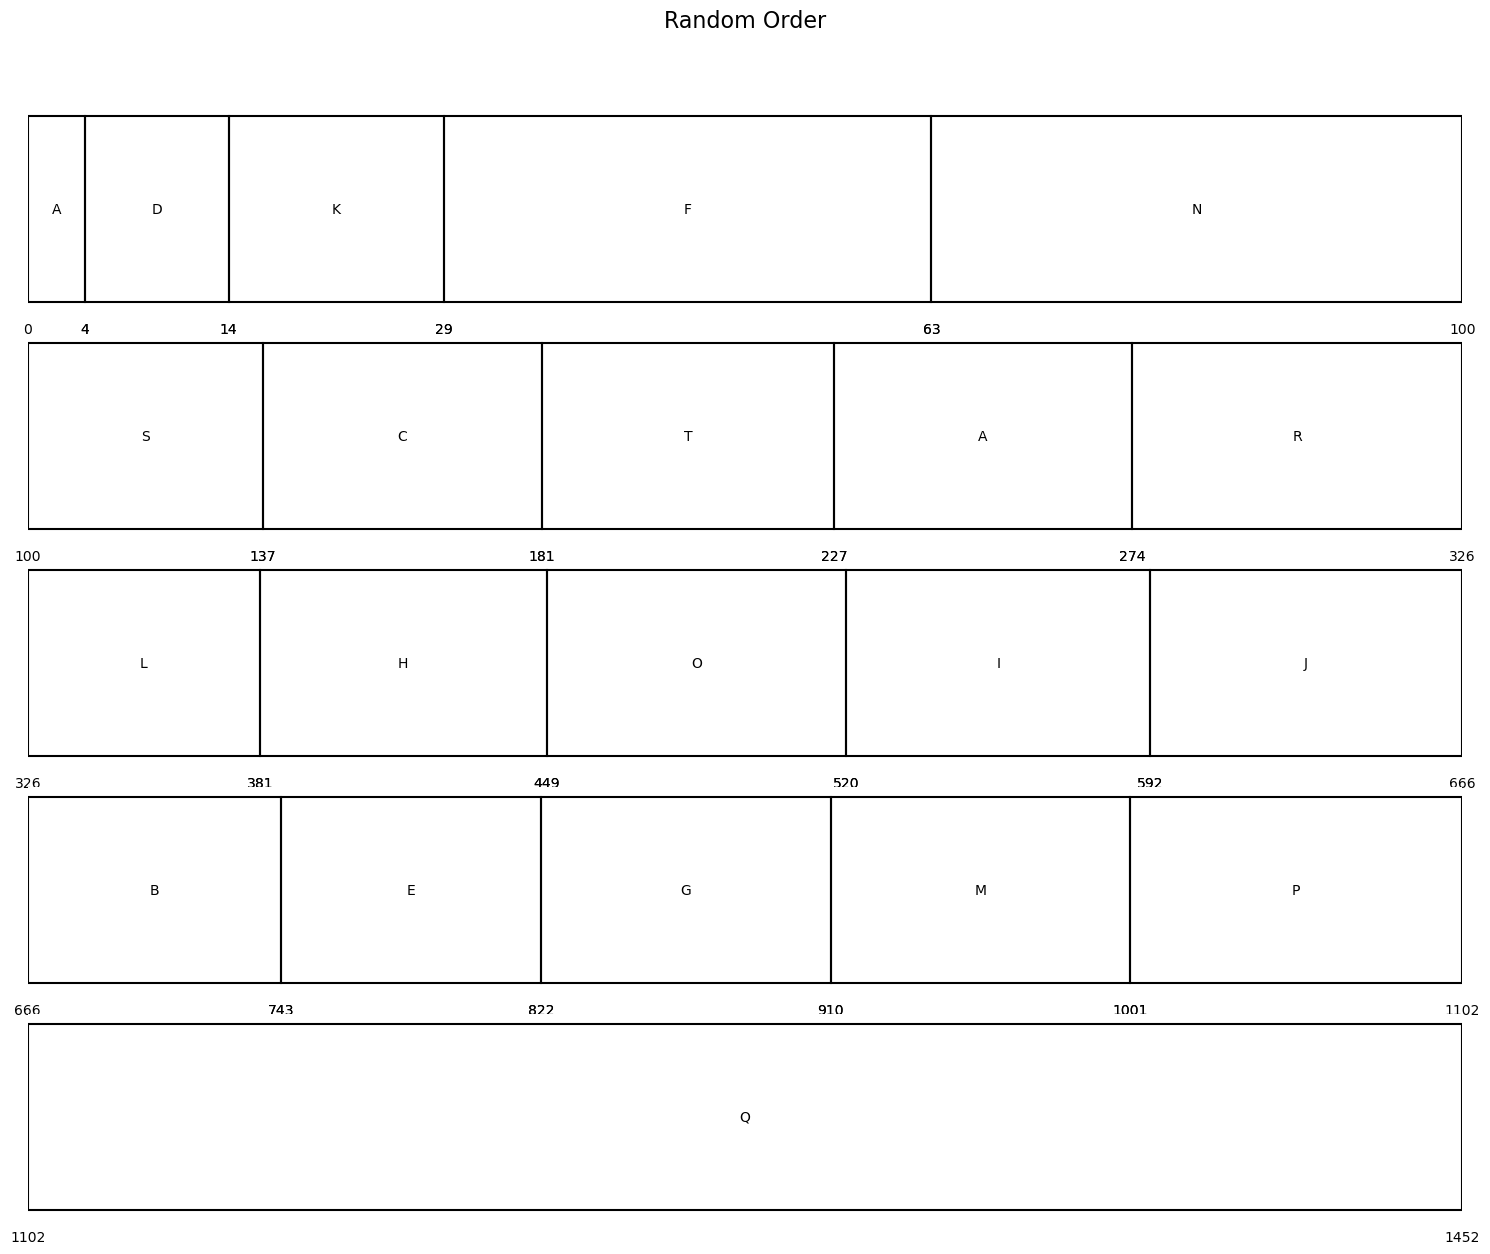

Context Switches: 20
Average Waiting Time: 417.35
Average Turnaround Time: 489.95


In [96]:
processes = [
    Process('A', 0, 51),
    Process('B', 1, 77),
    Process('C', 2, 44),
    Process('D', 3, 10),
    Process('E', 4, 79),
    Process('F', 5, 34),
    Process('G', 6, 88),
    Process('H', 7, 68),
    Process('I', 8, 72),
    Process('J', 9, 74),
    Process('K', 10, 15),
    Process('L', 11, 55),
    Process('M', 12, 91),
    Process('N', 13, 37),
    Process('O', 14, 71),
    Process('P', 15, 101),
    Process('Q', 16, 350),
    Process('R', 17, 52),
    Process('S', 18, 37),
    Process('T', 19, 46),
]

finished, timeline, cs = enhanced_round_robin(processes)
avg_waiting, avg_turnaround = compute_metrics(finished)
plot_gantt_charts(timeline, "Random Order")
print("Context Switches:", cs)
print("Average Waiting Time:", avg_waiting)
print("Average Turnaround Time:", avg_turnaround)